In [15]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score
import evaluationutility

In [9]:
# Logistic Regression Function

def lrcv(k, X, y, g):
    kf = GroupKFold(n_splits=k)
    mms = MinMaxScaler()
    # Train a logistic regression for each fold
    aucs = []
    kappas = []
    for train_index, test_index in kf.split(X, y, g):
        X_train, X_test = X[train_index], X[test_index]
        y_train_raw, y_test_raw = y[train_index], y[test_index]
        
        y_train = np.zeros((y_train_raw.size, y_train_raw.max()+1))
        y_train[np.arange(y_train_raw.size),y_train_raw] = 1
        y_test = np.zeros((y_test_raw.size, y_test_raw.max()+1))
        y_test[np.arange(y_test_raw.size),y_test_raw] = 1
        
        log_reg = LogisticRegression(max_iter=1000, multi_class='ovr')
        log_reg.fit(X_train, y_train_raw)
        y_pred = log_reg.predict_proba(X_test)
        y_pred = mms.fit_transform(y_pred)
        aucs.append(evaluationutility.auc(y_test, y_pred))
        kappas.append(evaluationutility.cohen_kappa_multiclass(y_test, y_pred))
        
    return np.mean(aucs), np.mean(kappas)

Max Pooling 1
Max Pooling 2
Max Pooling 4
Max Pooling 8
Max Pooling 16
Max Pooling 32
Max Pooling 64
Max Pooling 128
Max Pooling 256
Max Pooling 512
Mean Pooling 1
Mean Pooling 2
Mean Pooling 4
Mean Pooling 8
Mean Pooling 16
Mean Pooling 32
Mean Pooling 64
Mean Pooling 128
Mean Pooling 256
Mean Pooling 512
Max Pooling 1
Max Pooling 2
Max Pooling 4
Max Pooling 8
Max Pooling 16
Max Pooling 32
Max Pooling 64
Max Pooling 128
Max Pooling 256
Max Pooling 512
Mean Pooling 1
Mean Pooling 2
Mean Pooling 4
Mean Pooling 8
Mean Pooling 16
Mean Pooling 32
Mean Pooling 64
Mean Pooling 128
Mean Pooling 256
Mean Pooling 512


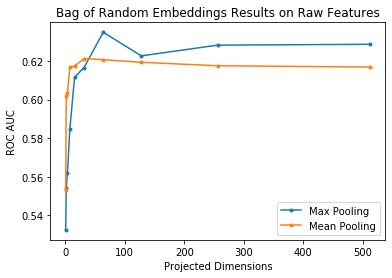

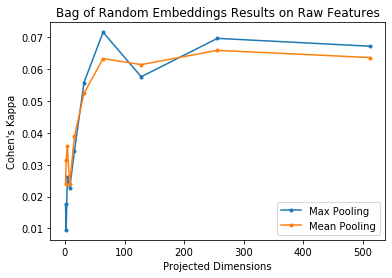

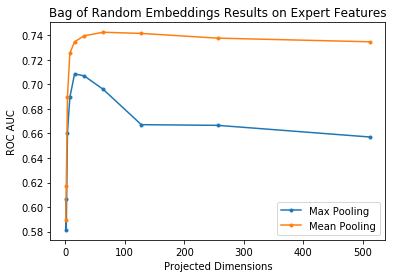

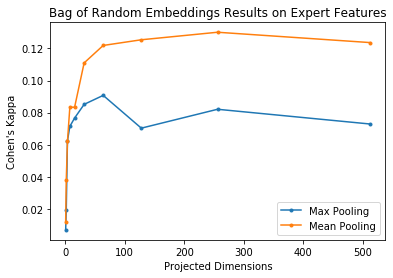

In [10]:
# Bag of Randomly Embedded Projections

TRIALS = 5
FOLDS = 5
MAX_POWER = 9

for source in ['raw', 'expert']:
    print(source)
    input_data = pk.load(open(f'data/bagged_{source}_input.pkl', 'rb'))
    target_data = pk.load(open(f'data/bagged_{source}_target.pkl', 'rb'))
    groups = np.array(pk.load(open(f'data/bagged_{source}_sid.pkl', 'rb')))
    pooling = []
    dimention = []
    auc = []
    kappa = []
    for pooling_name, pooling_function in zip(['Max Pooling', 'Mean Pooling'], [np.max, np.mean]):
        for dim in np.power(2, np.arange(MAX_POWER+1)):
            print(pooling_name, dim)
            aucs = []
            kappas = []
            for i in range(TRIALS):
                random_embedding = (np.random.rand(input_data[0].shape[1], dim) * 2 - 1) / np.sqrt(input_data[0].shape[1])
                log_input = []
                log_target = []
                for input_batch in input_data:
                    embedded_input = np.dot(input_batch, random_embedding)
                    embedded_input = pooling_function(embedded_input, axis=0)
                    log_input.append(embedded_input)
                log_input = np.stack(log_input)
                # Get the average auc and kappa for all affects and folds
                mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.argmax(target_data, axis=1).astype(int), groups)
                aucs.append(mean_auc)
                kappas.append(mean_kappa)
            pooling.append(pooling_name)
            dimention.append(log_input.shape[1])
            auc.append(np.mean(aucs))
            kappa.append(np.mean(kappas))
    plt.figure()
    plt.plot(dimention[:MAX_POWER+1], auc[:MAX_POWER+1], marker='.', label='Max Pooling')
    plt.plot(dimention[MAX_POWER+1:], auc[MAX_POWER+1:], marker='.', label='Mean Pooling')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('ROC AUC')
    plt.title('Bag of Random Embeddings Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/borep_{source}_auc.png', dpi=300)
    plt.figure()
    plt.plot(dimention[:MAX_POWER+1], kappa[:MAX_POWER+1], marker='.', label='Max Pooling')
    plt.plot(dimention[MAX_POWER+1:], kappa[MAX_POWER+1:], marker='.', label='Mean Pooling')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('Cohen\'s Kappa')
    plt.title('Bag of Random Embeddings Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/borep_{source}_kappa.png', dpi=300)

raw
0 1
0 2
0 4
0 8
0 16
0 32
0 64
0 128
0 256
0 512
1 1
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
2 1
2 2
2 4
2 8
2 16
2 32
2 64
2 128
2 256
2 512
3 1
3 2
3 4
3 8
3 16
3 32
3 64
3 128
3 256
3 512
4 1
4 2
4 4
4 8
4 16
4 32
4 64
4 128
4 256
4 512
expert
0 1
0 2
0 4
0 8
0 16
0 32
0 64
0 128
0 256
0 512
1 1
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
2 1
2 2
2 4
2 8
2 16
2 32
2 64
2 128
2 256
2 512
3 1
3 2
3 4
3 8
3 16
3 32
3 64
3 128
3 256
3 512
4 1
4 2
4 4
4 8
4 16
4 32
4 64
4 128
4 256
4 512


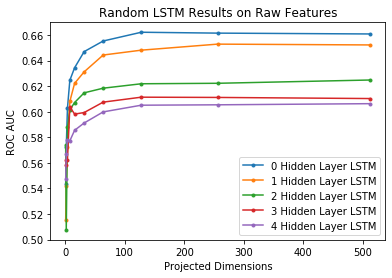

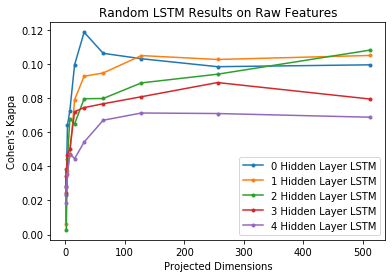

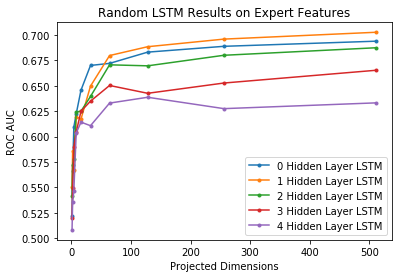

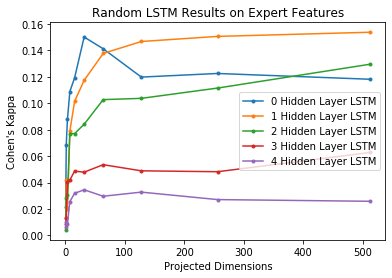

In [28]:
# RLSTM

TRIALS = 5
FOLDS = 5
MAX_POWER = 9
LAYERS = 5

for source in ['raw', 'expert']:
    print(source)
    input_data = pk.load(open(f'data/bagpad_{source}_input.pkl', 'rb'))
    input_data = np.stack(input_data)
    target_data = pk.load(open(f'data/bagpad_{source}_target.pkl', 'rb'))
    target_data = np.stack(target_data)
    groups = np.array(pk.load(open(f'data/bagged_{source}_sid.pkl', 'rb')))
    layers = []
    dimention = []
    auc = []
    kappa = []
    for lay in range(LAYERS):
        for dim in np.power(2, np.arange(MAX_POWER+1)):
            print(lay, dim)
            aucs = []
            kappas = []
            for i in range(TRIALS):
                # Make the LSTM
                keras.backend.clear_session()
                rand_lstm = Sequential()
                rand_lstm.add(InputLayer(input_shape=(input_data[0].shape)))
                for l in range(lay):
                    rand_lstm.add(LSTM(dim, activation='tanh', return_sequences=True))
                rand_lstm.add(LSTM(dim, activation='sigmoid', return_sequences=False))
                rand_lstm.compile(optimizer='adam', loss='categorical_crossentropy')
                # Project each input into higher dimensions
                log_input = rand_lstm.predict(input_data)
                log_target = target_data[:,-1,:]
                # Get the average auc and kappa for all affects and folds
                mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.argmax(log_target, axis=1).astype(int), groups)
                aucs.append(mean_auc)
                kappas.append(mean_kappa)
            layers.append(lay)
            dimention.append(log_input.shape[1])
            auc.append(np.mean(aucs))
            kappa.append(np.mean(kappas))
    plt.figure()
    for i in range(LAYERS):
        plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], auc[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i} Hidden Layer LSTM')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('ROC AUC')
    plt.title('Random LSTM Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/lstm_{source}_auc.png', dpi=300)
    plt.figure()
    for i in range(LAYERS):
        plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], kappa[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i} Hidden Layer LSTM')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('Cohen\'s Kappa')
    plt.title('Random LSTM Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/lstm_{source}_kappa.png', dpi=300)

raw
0 1
0 2
0 4
0 8
0 16
0 32
0 64
0 128
0 256
0 512
1 1
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
2 1
2 2
2 4
2 8
2 16
2 32
2 64
2 128
2 256
2 512
3 1
3 2
3 4
3 8
3 16
3 32
3 64
3 128
3 256
3 512
4 1
4 2
4 4
4 8
4 16
4 32
4 64
4 128
4 256
4 512
expert
0 1
0 2
0 4
0 8
0 16
0 32
0 64
0 128
0 256
0 512
1 1
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
2 1
2 2
2 4
2 8
2 16
2 32
2 64
2 128
2 256
2 512
3 1
3 2
3 4
3 8
3 16
3 32
3 64
3 128
3 256
3 512
4 1
4 2
4 4
4 8
4 16
4 32
4 64
4 128
4 256
4 512


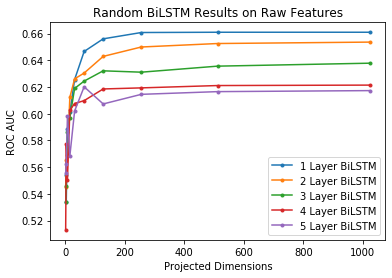

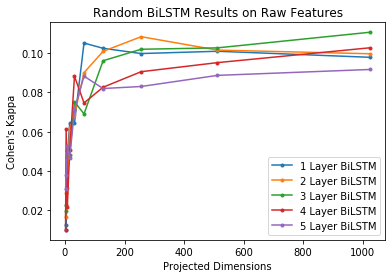

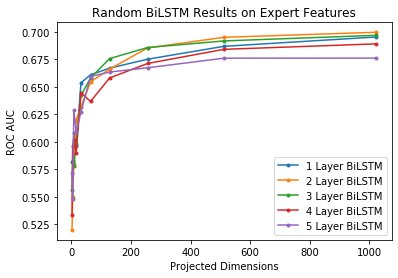

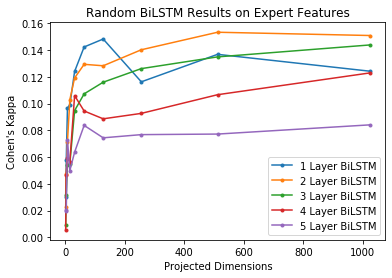

In [32]:
# Random BiLSTM

TRIALS = 5
FOLDS = 5
MAX_POWER = 9
LAYERS = 5

for source in ['raw', 'expert']:
    print(source)
    input_data = pk.load(open(f'data/bagpad_{source}_input.pkl', 'rb'))
    input_data = np.stack(input_data)
    target_data = pk.load(open(f'data/bagpad_{source}_target.pkl', 'rb'))
    target_data = np.stack(target_data)
    groups = np.array(pk.load(open(f'data/bagged_{source}_sid.pkl', 'rb')))
    layers = []
    dimention = []
    auc = []
    kappa = []
    for lay in range(LAYERS):
        for dim in np.power(2, np.arange(MAX_POWER+1)):
            print(lay, dim)
            aucs = []
            kappas = []
            for i in range(TRIALS):
                # Make the BiLSTM
                keras.backend.clear_session()
                rand_bilstm = Sequential()
                rand_bilstm.add(InputLayer(input_shape=(input_data[0].shape)))
                for l in range(lay):
                    rand_bilstm.add(Bidirectional(LSTM(dim, activation='tanh', return_sequences=True)))
                rand_bilstm.add(Bidirectional(LSTM(dim, activation='sigmoid', return_sequences=False)))
                rand_bilstm.compile(optimizer='adam', loss='categorical_crossentropy')
                # Project each input into higher dimensions
                log_input = rand_bilstm.predict(input_data)
                log_target = target_data[:,-1,:]
                # Get the average auc and kappa for all affects and folds
                mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.argmax(log_target, axis=1).astype(int), groups)
                aucs.append(mean_auc)
                kappas.append(mean_kappa)
            layers.append(lay)
            dimention.append(log_input.shape[1])
            auc.append(np.mean(aucs))
            kappa.append(np.mean(kappas))
    plt.figure()
    for i in range(LAYERS):
        plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], auc[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer BiLSTM')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('ROC AUC')
    plt.title('Random BiLSTM Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/bilstm_{source}_auc.png', dpi=300)
    plt.figure()
    for i in range(LAYERS):
        plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], kappa[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer BiLSTM')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('Cohen\'s Kappa')
    plt.title('Random BiLSTM Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/bilstm_{source}_kappa.png', dpi=300)

raw
0 1
0 2
0 4
0 8
0 16
0 32
0 64
0 128
0 256
0 512
1 1
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
2 1
2 2
2 4
2 8
2 16
2 32
2 64
2 128
2 256
2 512
3 1
3 2
3 4
3 8
3 16
3 32
3 64
3 128
3 256
3 512
4 1
4 2
4 4
4 8
4 16
4 32
4 64
4 128
4 256
4 512
expert
0 1
0 2
0 4
0 8
0 16
0 32
0 64
0 128
0 256
0 512
1 1
1 2
1 4
1 8
1 16
1 32
1 64
1 128
1 256
1 512
2 1
2 2
2 4
2 8
2 16
2 32
2 64
2 128
2 256
2 512
3 1
3 2
3 4
3 8
3 16
3 32
3 64
3 128
3 256
3 512
4 1
4 2
4 4
4 8
4 16
4 32
4 64
4 128
4 256
4 512


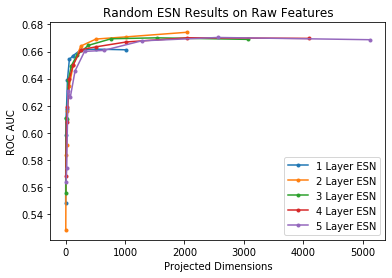

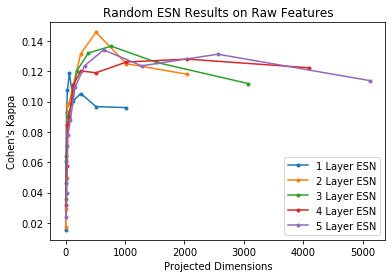

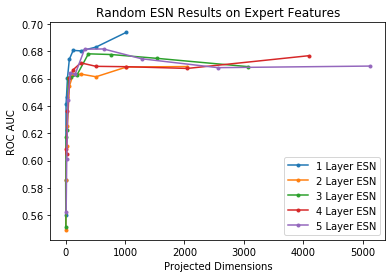

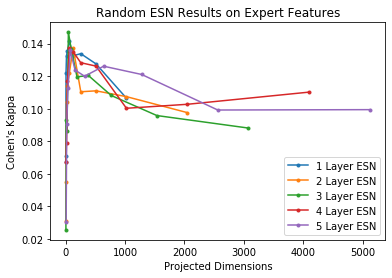

In [51]:
# Random Pseudo-ESN

TRIALS = 5
FOLDS = 5
MAX_POWER = 9
LAYERS = 5

for source in ['raw', 'expert']:
    print(source)
    input_data = pk.load(open(f'data/bagpad_{source}_input.pkl', 'rb'))
    input_data = np.stack(input_data)
    target_data = pk.load(open(f'data/bagpad_{source}_target.pkl', 'rb'))
    target_data = np.stack(target_data)
    groups = np.array(pk.load(open(f'data/bagged_{source}_sid.pkl', 'rb')))
    layers = []
    dimention = []
    auc = []
    kappa = []
    for lay in range(LAYERS):
        for dim in np.power(2, np.arange(MAX_POWER+1)):
            print(lay, dim)
            aucs = []
            kappas = []
            for i in range(TRIALS):
                # Make the BiLSTM
                keras.backend.clear_session()
                rand_bilstm = Sequential()
                rand_bilstm.add(InputLayer(input_shape=(input_data[0].shape)))
                for l in range(lay):
                    rand_bilstm.add(Bidirectional(LSTM(dim, activation='tanh', return_sequences=True)))
                rand_bilstm.add(Bidirectional(LSTM(dim, activation='sigmoid', return_sequences=True)))
                outputs = [l.output for l in rand_bilstm.layers]
                esn = keras.Model(inputs=rand_bilstm.inputs, outputs=outputs)
                esn.compile(optimizer='adam', loss='categorical_crossentropy')
                # Project each input into higher dimensions
                log_input = []
                if lay == 0:
                    log_input = np.stack([x[-1,:] for x in esn.predict(input_data)])
                else:
                    log_input = np.concatenate([x[:,-1,:] for x in esn.predict(input_data)], axis=1)
                log_target = target_data[:,-1,:]
                # Get the average auc and kappa for all affects and folds
                mean_auc, mean_kappa = lrcv(FOLDS, log_input, np.argmax(log_target, axis=1).astype(int), groups)
                aucs.append(mean_auc)
                kappas.append(mean_kappa)
            layers.append(lay)
            dimention.append(log_input.shape[1])
            auc.append(np.mean(aucs))
            kappa.append(np.mean(kappas))
    plt.figure()
    for i in range(LAYERS):
        plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], auc[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer ESN')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('ROC AUC')
    plt.title('Random ESN Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/esn_{source}_auc.png', dpi=300)

    plt.figure()
    for i in range(LAYERS):
        plt.plot(dimention[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], kappa[i*(MAX_POWER+1):i*(MAX_POWER+1)+MAX_POWER+1], marker='.', label=f'{i+1} Layer ESN')
    plt.xlabel('Projected Dimensions')
    plt.ylabel('Cohen\'s Kappa')
    plt.title('Random ESN Results on ' + ('Raw' if source == 'raw' else 'Expert') + ' Features')
    plt.legend()
    plt.savefig(f'gs/esn_{source}_kappa.png', dpi=300)